In [1]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoRegResults
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
dados_f1 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F1.csv'
dados_f2 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F2.csv'
dados_f3 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F3.csv'

Setor agropecuário solicitou previsões de temperaturas mensais para os próximos três anos em três locais onde planejam abrir novas fazendas.

# Fazenda 1

In [4]:
df_f1 = pd.read_csv(dados_f1)
df_f1

,DATA,TEMP
0,1963-05-01,23.11
1,1963-06-01,24.20
2,1963-07-01,25.37
3,1963-08-01,23.86
4,1963-09-01,23.03
...,...,...
727,2023-12-01,19.49
728,2024-01-01,19.28
729,2024-02-01,19.73
730,2024-03-01,20.44


In [5]:
df_f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATA    732 non-null    object 
 1   TEMP    732 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.6+ KB


In [6]:
df_f1['DATA'] = pd.to_datetime(df_f1['DATA'], format='%Y-%m-%d')
df_f1.set_index('DATA', inplace=True, drop=True)

In [7]:
df_f1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 1963-05-01 to 2024-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    732 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


<Axes: title={'center': 'Temperatura média mensal - F1'}, xlabel='DATA'>

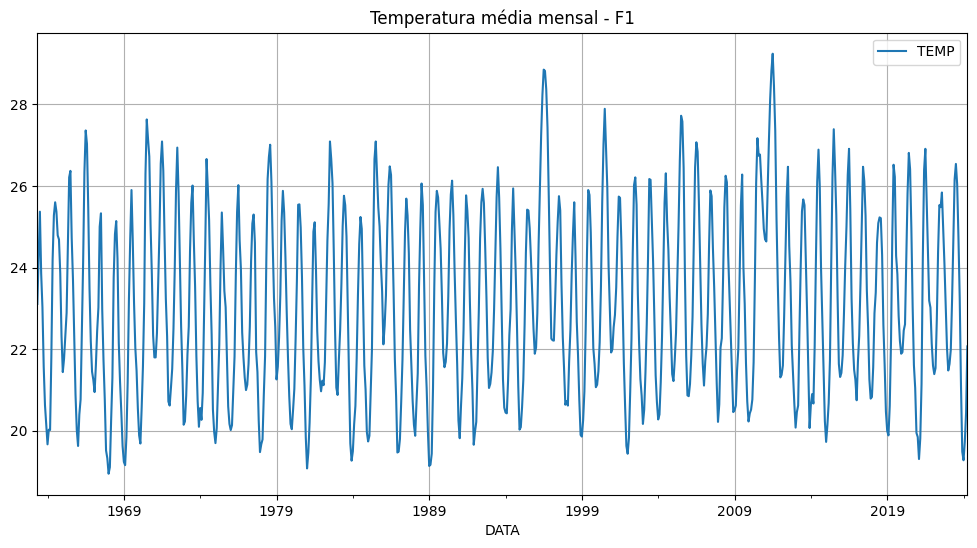

In [8]:
df_f1.plot(figsize=(12, 6), title='Temperatura média mensal - F1', legend=True, grid=True)

meses mais frios, meses mais quentes

In [9]:
df_f1

,TEMP
DATA,
1963-05-01,23.11
1963-06-01,24.20
1963-07-01,25.37
1963-08-01,23.86
1963-09-01,23.03
...,...
2023-12-01,19.49
2024-01-01,19.28
2024-02-01,19.73


## Avaliando a estacionariedade

Para determinar o modelo ideal a ser aplicado, é necessário realizar uma análise detalhada da série temporal, identificando características essenciais que ela deve ter. 

Uma série temporal é considerada estacionária quando sua média e variância permanecem constantes ao longo do tempo, o que indica que não é afetada por tendências ou componentes sazonais.

Os valores futuros dependem dos valores passados. Portanto, podemos aplicar um modelo que compreende essas relações passadas para fazer previsões sobre o futuro.

In [10]:
def estac(df):
    adf = adfuller(df['TEMP'])
    print(f'Valor-p do teste ADF: {adf[1]: .4f}')
    if adf[1] > 0.05:
        print('Série não estacionária')
    else:
        print('Série estacionária')

    
    kpss_saida = kpss(df)
    print(f'Valor-p do Teste KPSS: {kpss_saida[1]: .4f}')
    if kpss_saida[1] > 0.05:
        print('Série estacionária')
    else:
        print('Série não estacionária')


In [11]:
estac(df_f1)

Valor-p do teste ADF:  0.0000
Série estacionária
Valor-p do Teste KPSS:  0.0798
Série estacionária


In [12]:
divisao = int(len(df_f1) * 0.7)
df_treino = df_f1.iloc[:divisao].asfreq('MS')  # MS = Month Start
df_teste = df_f1.iloc[divisao:].asfreq('MS')

In [13]:
df_treino

,TEMP
DATA,
1963-05-01,23.11
1963-06-01,24.20
1963-07-01,25.37
1963-08-01,23.86
1963-09-01,23.03
...,...
2005-08-01,27.58
2005-09-01,26.44
2005-10-01,23.86


## Modelo Autoregressivo (AR)

Um modelo Autorregressivo (AR) é um tipo de modelo de previsão para séries temporais que utiliza uma combinação linear de valores passados da própria série para fazer previsões futuras. Ele se baseia na ideia de que observações passadas podem ser usadas para prever observações futuras de maneira estatisticamente significativa, especialmente quando a série exibe correlação ao longo do tempo.

A equação básica de um modelo autorregressivo de ordem $(p)$ (lag de $p$ períodos) é dada por:

$X_t = c + \beta_1 X_{t-1} + \beta_2 X_{t-2} + \dots + \beta_p X_{t-p} + \epsilon_t$

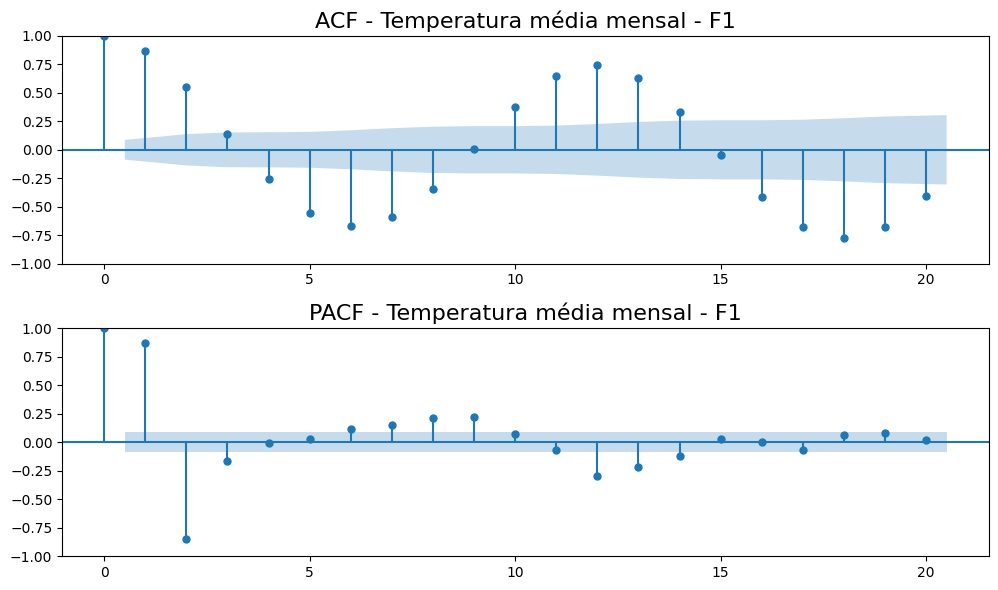

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(df_treino, lags=20, ax=ax1)
ax1.set_title('ACF - Temperatura média mensal - F1', fontsize=16)

plot_pacf(df_treino, lags=20, ax=ax2)
ax2.set_title('PACF - Temperatura média mensal - F1', fontsize=16)

plt.tight_layout()
plt.show()

### Construindo modelo autorregressivo

In [15]:
ar_mod = AutoReg(df_treino, 14, old_names=False)
ar_res = ar_mod.fit()
print(ar_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(14)   Log Likelihood                -317.490
Method:               Conditional MLE   S.D. of innovations              0.458
Date:                Fri, 06 Jun 2025   AIC                            666.981
Time:                        13:04:26   BIC                            734.350
Sample:                    07-01-1964   HQIC                           693.421
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0973      0.649      7.855      0.000       3.825       6.369
TEMP.L1        1.1971      0.044     27.078      0.000       1.110       1.284
TEMP.L2       -0.3092      0.069     -4.470      0.0

### Verificando previsões do modelo AR

Garantir que as previsões futuras desse modelo sejam boas e sejam equivalentes aos valores esperados.

Logo, precisamos comparar as previsões geradas pelo modelo com os valores esperados, os quais já separamos em um conjunto de teste.

c:\Users\mborges\Downloads\TimeSeriesAlura\previsao_tempo\venv\Lib\site-packages\statsmodels\tsa\ar_model.py:1138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_params[lag] = -params[i]


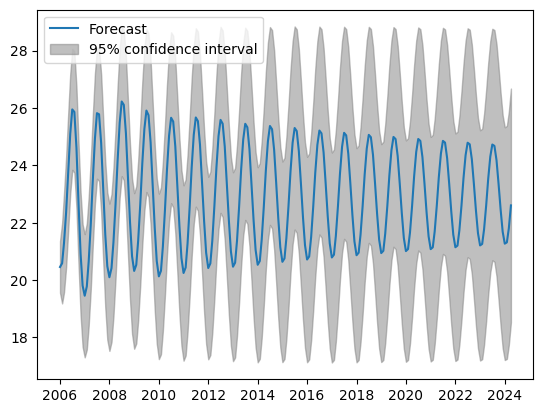

In [16]:
mod_result = AutoRegResults(ar_mod, ar_res.params, ar_res.cov_params())
fig = mod_result.plot_predict(len(df_treino), len(df_treino)+ len(df_teste)-1)

começa onde o conjunto de treino termina e termina no tempo do conjunto de teste

In [17]:

def plot_prev(treino, teste, mod, nome_mod = ''):

  previsoes = mod.predict(len(treino), len(treino) + len(teste)-1, dynamic=False)

  plt.figure(figsize=(12, 5))

  plt.plot(teste.index, teste, label='Esperado')
  plt.plot(previsoes.index, previsoes, label='Previsto', color='red')

  plt.title(f'Previsão modelo {nome_mod}')
  plt.ylabel('Temperatura')
  plt.legend()
  plt.show()

  print('\nMétricas:\n')
  mae = mean_absolute_error(teste, previsoes)
  print(f'MAE: {mae}')

  mse = mean_squared_error(teste, previsoes)
  print(f'MSE: {mse}')

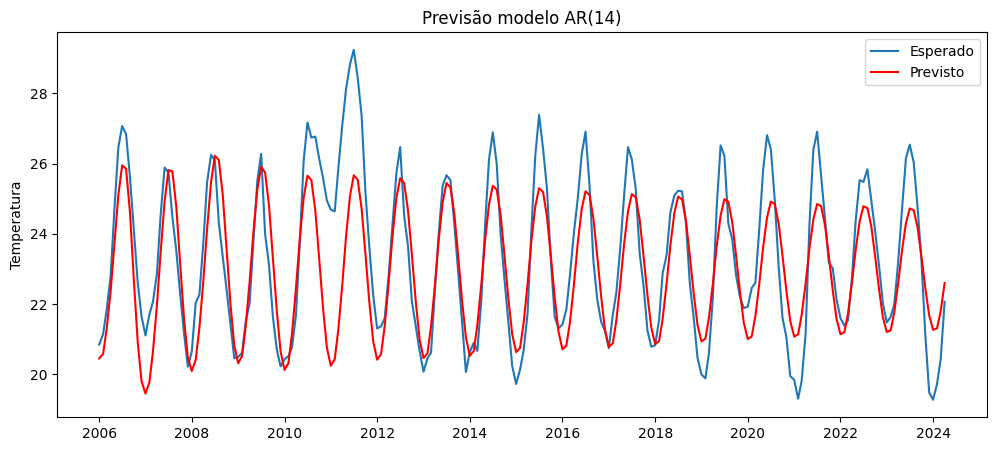


Métricas:

MAE: 1.0427063983973868
MSE: 1.8489038142171543


In [18]:
plot_prev(df_treino, df_teste, ar_res, 'AR(14)')

Os valores previstos estão diminuindo, como se estivessem convergindo para um ponto, mesmo que nossos dados não apresentem esse comportamento.

Devemos tentar melhorar nosso modelo para que ele se adaptasse melhor aos nossos dados. 

Uma opção é buscar novos valores para a nossa ordem P, que definimos anteriormente. Podemos testar todos os valores de P possíveis para o nosso modelo e selecionar aquele que teve o melhor desempenho.

### Busca de parâmetros

Buscando o melhor valor P

In [19]:
ar_selecao = ar_select_order(df_treino, 35, old_names=False, ic="aic")

In [20]:
ar_selecao.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [21]:
ar_sel_res = ar_selecao.model.fit()
print(ar_sel_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(34)   Log Likelihood                -265.842
Method:               Conditional MLE   S.D. of innovations              0.422
Date:                Fri, 06 Jun 2025   AIC                            603.684
Time:                        13:04:27   BIC                            753.790
Sample:                    03-01-1966   HQIC                           662.698
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      1.091      4.092      0.000       2.326       6.603
TEMP.L1        1.1355      0.045     25.067      0.000       1.047       1.224
TEMP.L2       -0.2017      0.068     -2.958      0.0

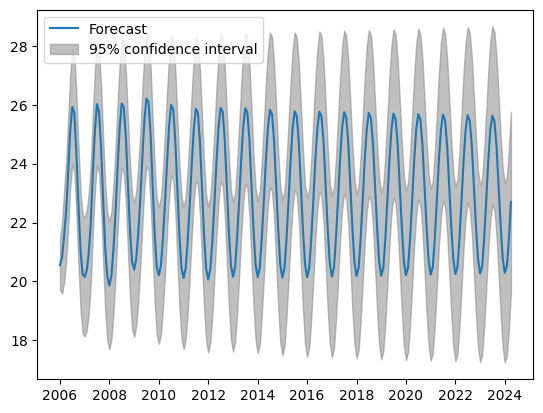

In [22]:
ig = ar_sel_res.plot_predict(len(df_treino), len(df_treino) + len(df_teste) - 1)

As curvas, aparentemente, já sustentam mais, pois não estão fazendo aquela convergência de antes. 

Também conseguimos observar que, justamente por conta disso, a nossa área de confiança ficou mais estreita em relação à previsão anterior, que tinha uma área bem mais expandida. Isso é bom, pois pode trazer uma confiança maior para os nossos resultados.

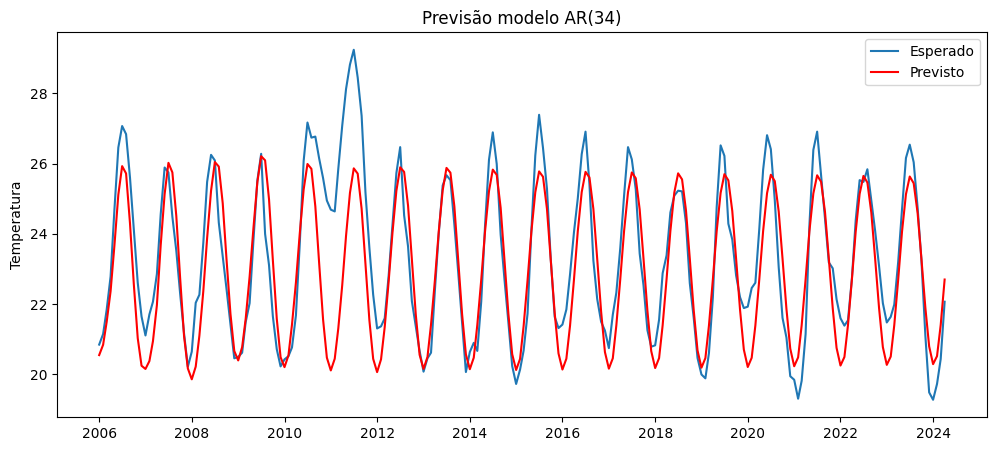


Métricas:

MAE: 0.9474776896250366
MSE: 1.6610673113369703


In [23]:
plot_prev(df_treino,df_teste,ar_sel_res,'AR(34)')

# Fazenda 2

In [24]:
df_f2 = pd.read_csv(dados_f2)

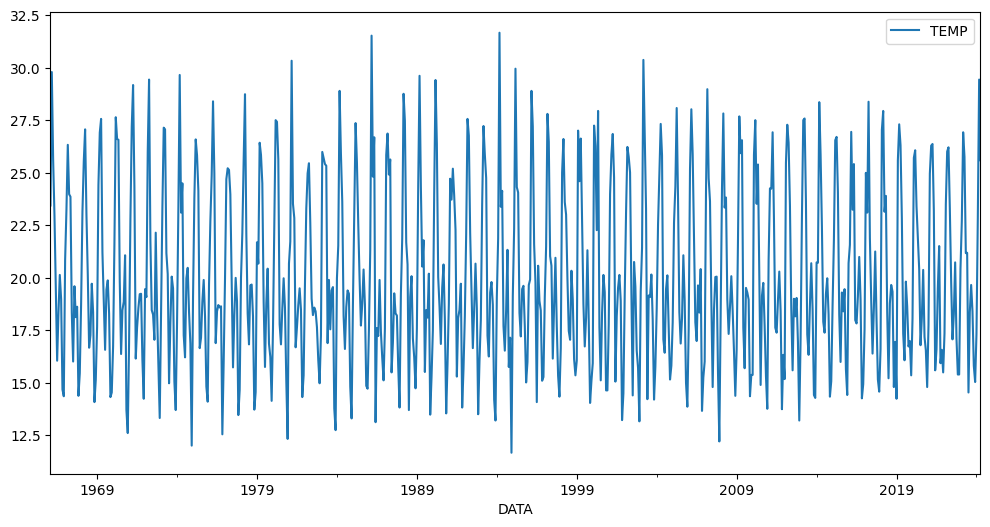

In [25]:
df_f2['DATA'] = pd.to_datetime(df_f2['DATA'], format='%Y-%m-%d')
df_f2.set_index(['DATA'], inplace=True, drop=True)
fig = df_f2.plot(figsize=(12, 6))

In [26]:
estac(df_f2)

Valor-p do teste ADF:  0.0000
Série estacionária
Valor-p do Teste KPSS:  0.1000
Série estacionária


C:\Users\mborges\AppData\Local\Temp\ipykernel_27400\3572946095.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_saida = kpss(df)


In [27]:
divisao = int(len(df_f2) * 0.8)

df_treino = df_f2.iloc[:divisao].asfreq('MS')
df_teste = df_f2.iloc[divisao:].asfreq('MS')

## Construindo um modelo previsivo

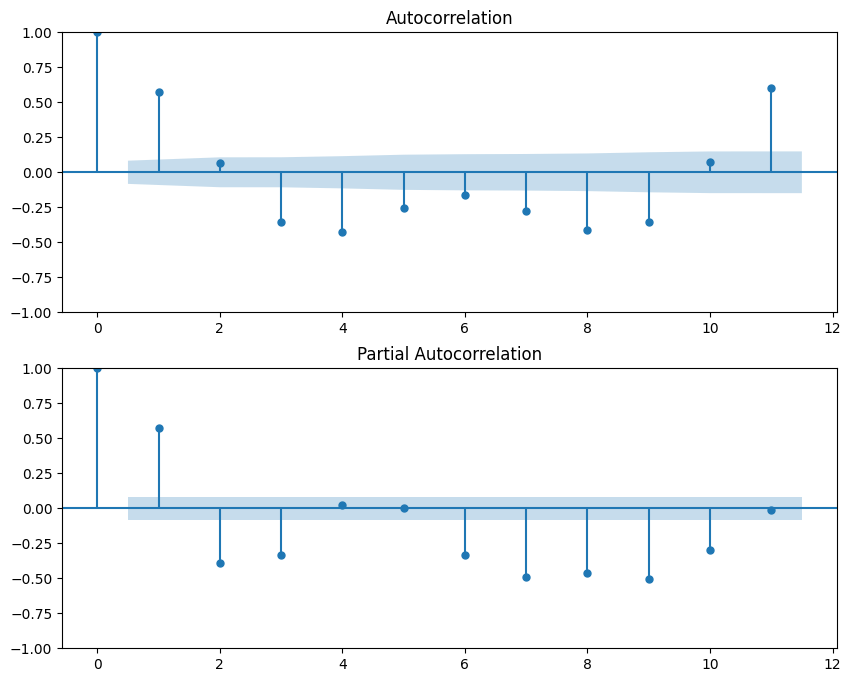

In [28]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_treino, lags=11, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_treino, lags=11, ax=ax2)

In [29]:
ar_mod_f2 = AutoReg(df_treino, 10, old_names=False)
ar_res_f2 = ar_mod_f2.fit()
print(ar_res_f2.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                    AutoReg(10)   Log Likelihood                -993.284
Method:               Conditional MLE   S.D. of innovations              1.477
Date:                Fri, 06 Jun 2025   AIC                           2010.569
Time:                        13:04:28   BIC                           2062.266
Sample:                    12-01-1966   HQIC                          2030.773
                         - 08-01-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.9748      3.244     34.518      0.000     105.617     118.333
TEMP.L1       -0.3349      0.037     -9.170      0.000      -0.406      -0.263
TEMP.L2       -0.3242      0.030    -10.926      0.0

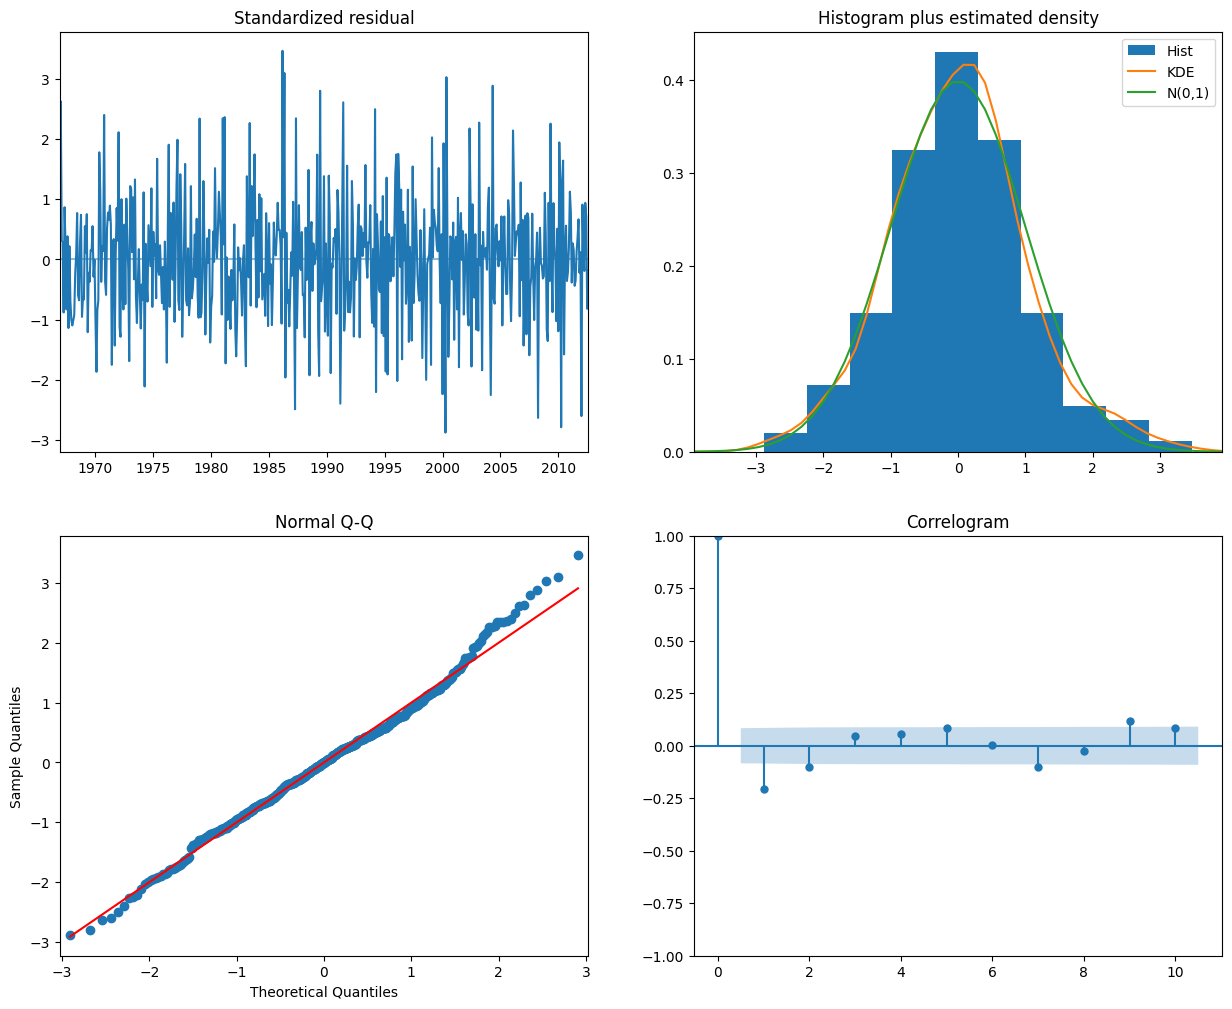

In [30]:
ar_res_f2.plot_diagnostics(figsize=(15,12))
plt.show()

Correlograma: funciona como uma análise de autocorrelação dos resíduos. Quando os resíduos apresentam autocorrelação, podem indicar que há uma dependência dos erros das nossas previsões e que esses erros estão sendo propagados entre as previsões passadas, o que não é desejável para previsões futuras.

Podemos identificar essa propagação ao observar os valores dentro do correlograma que, a partir do lag 1, estão fora da faixa azul.

### Modelo Autorregressivo de Médias Móveis (ARMA)

O modelo ARMA é uma ferramenta estatística avançada usada na análise de séries temporais que combina duas características principais: autoregressiva (AR) e média móvel (MA).

O modelo ARMA é expresso pela seguinte equação:

$X_t = c + \epsilon_t + \sum_{i=1}^p \beta_i X_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j}$

In [31]:
arma_mod = ARIMA(df_treino, order=(10, 0, 1)).fit()
print(arma_mod.summary())

c:\Users\mborges\Downloads\TimeSeriesAlura\previsao_tempo\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                ARIMA(10, 0, 1)   Log Likelihood                -988.509
Date:                Fri, 06 Jun 2025   AIC                           2003.018
Time:                        13:04:29   BIC                           2059.257
Sample:                    02-01-1966   HQIC                          2024.979
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9727      0.008   2365.649      0.000      19.956      19.989
ar.L1         -0.0891      0.058     -1.544      0.123      -0.202       0.024
ar.L2         -0.3212      0.034     -9.505      0.0

c:\Users\mborges\Downloads\TimeSeriesAlura\previsao_tempo\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


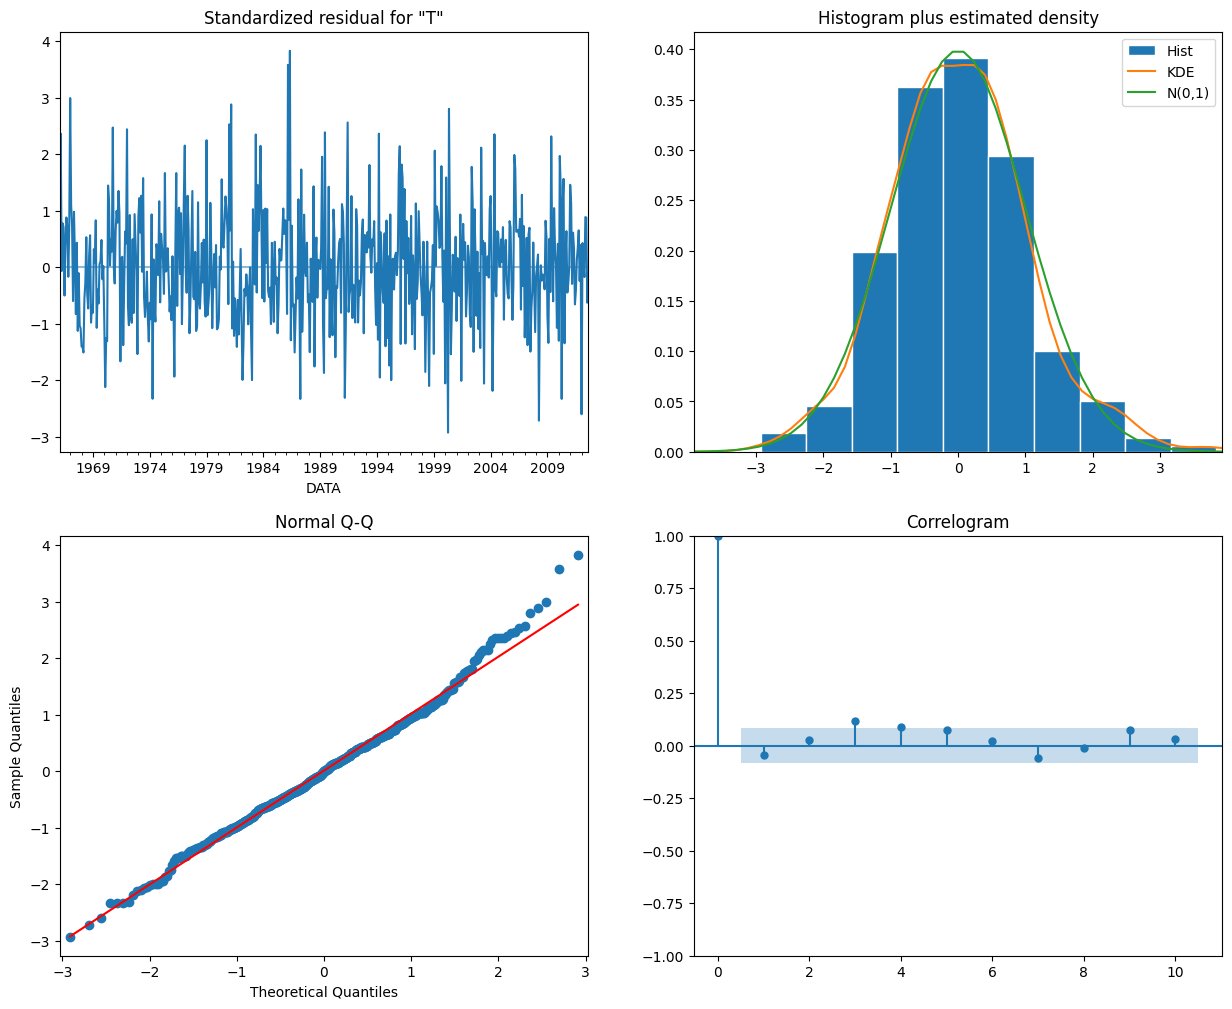

In [32]:
arma_mod.plot_diagnostics(figsize=(15, 12))
plt.show()

### Busca de parâmetros

In [33]:
import itertools
import warnings
warnings.filterwarnings("ignore")


def grid_arima(p_inicial, p_final, q_inicial, q_final, d_valores, treino):
  # Definindo os parâmetros
  p_params = range(p_inicial, p_final)
  q_params = range(q_inicial, q_final)
  d_params = [d_valores]

  # Gerando todas as combinações possíveis usando product
  combinacoes = list(itertools.product(p_params, d_params, q_params))

  aic_grid = dict()
  # Treinando o modelo e salvando todas combinações
  for order in combinacoes:
    try:
      model = ARIMA(treino, order = order).fit()
      aic_grid[order] = list()
      aic_grid[order].append((model.aic if model.aic else float('inf')))
    except:
      continue
  return aic_grid, min(aic_grid, key=lambda x: aic_grid[x][0])

In [34]:
aic_arma = grid_arima(10,25,1,3,0,df_treino)

In [35]:
aic_arma[1]

(24, 0, 2)

In [36]:
arma_mod_ot = ARIMA(df_treino, order=aic_arma[1]).fit()
print(arma_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                ARIMA(24, 0, 2)   Log Likelihood                -934.111
Date:                Fri, 06 Jun 2025   AIC                           1924.222
Time:                        13:06:20   BIC                           2045.355
Sample:                    02-01-1966   HQIC                          1971.525
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9729      0.004   4630.319      0.000      19.964      19.981
ar.L1         -0.4115      0.318     -1.296      0.195      -1.034       0.211
ar.L2          0.1878      0.130      1.444      0.1

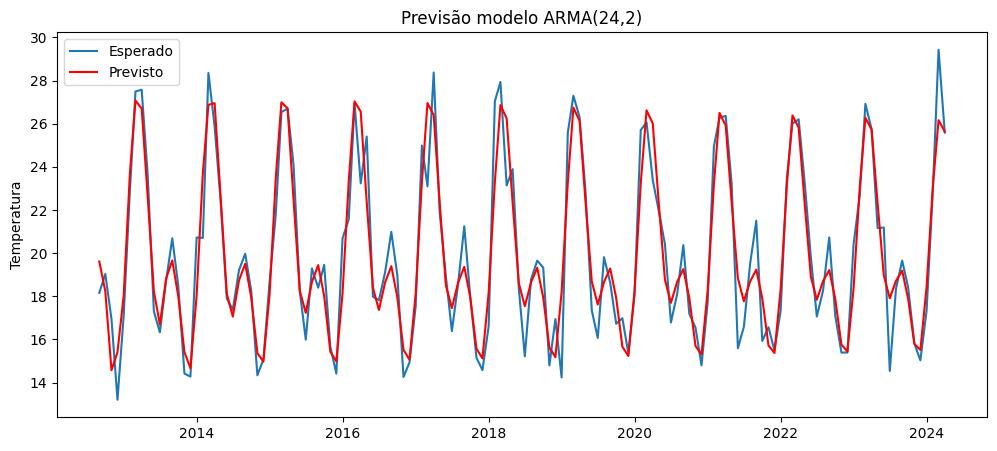


Métricas:

MAE: 1.0654759243285838
MSE: 1.9803190570461036


In [37]:
plot_prev(df_treino, df_teste, arma_mod_ot, 'ARMA(24,2)')

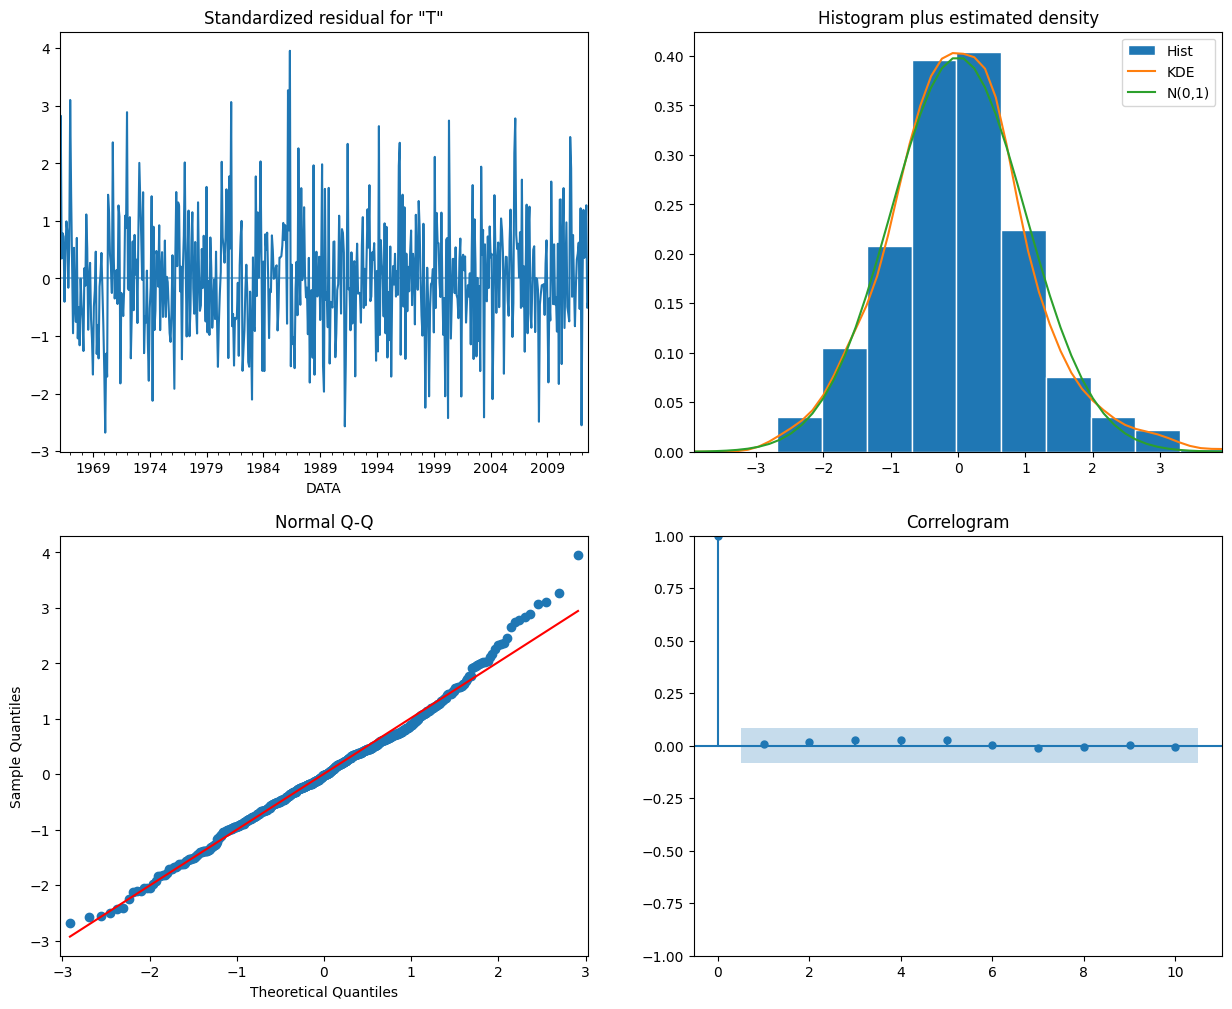

In [38]:
arma_mod_ot.plot_diagnostics(figsize=(15, 12))
plt.show()

# Fazenda 3

In [39]:
df_f3 = pd.read_csv(dados_f3)
df_f3

,DATA,TEMP
0,1965-09-01,33.30
1,1965-10-01,32.88
2,1965-11-01,30.28
3,1965-12-01,30.42
4,1966-01-01,30.39
...,...,...
699,2023-12-01,31.72
700,2024-01-01,32.22
701,2024-02-01,32.29
702,2024-03-01,29.60


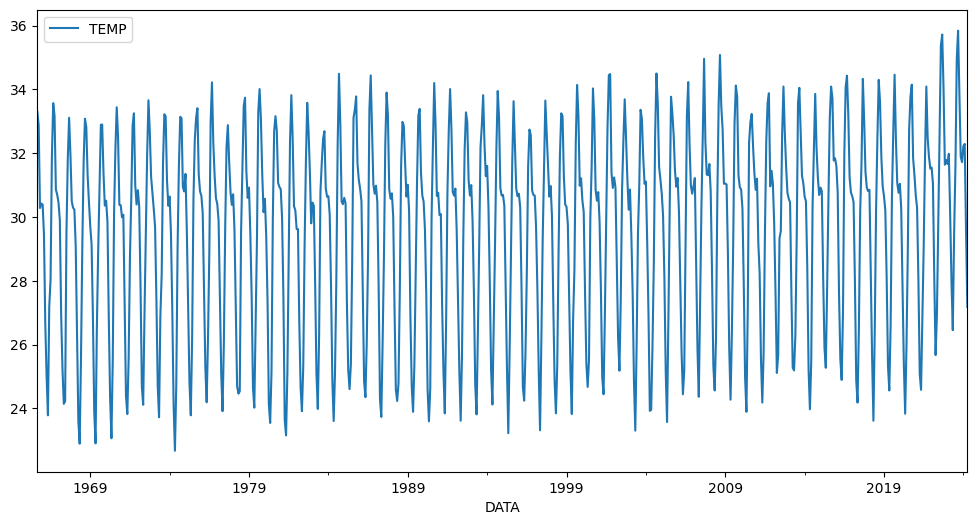

In [40]:
df_f3['DATA'] = pd.to_datetime(df_f3['DATA'], format='%Y-%m-%d')
df_f3.set_index(['DATA'], inplace=True, drop=True)
fig = df_f3.plot(figsize=(12, 6))

In [41]:
estac(df_f3)

Valor-p do teste ADF:  0.0669
Série não estacionária
Valor-p do Teste KPSS:  0.0100
Série não estacionária


### Diferenciação

In [42]:
df_f3.diff(1)

,TEMP
DATA,
1965-09-01,NaN
1965-10-01,-0.42
1965-11-01,-2.60
1965-12-01,0.14
1966-01-01,-0.03
...,...
2023-12-01,-0.16
2024-01-01,0.50
2024-02-01,0.07


In [43]:
estac(df_f3.diff(1).iloc[1:])

Valor-p do teste ADF:  0.0000
Série estacionária
Valor-p do Teste KPSS:  0.1000
Série estacionária


## Modelo Integrado Autorregressivo de Média Móveis (ARIMA)

In [44]:
divisao = int(len(df_f3) * 0.8)

df_treino = df_f3.iloc[:divisao].asfreq('MS')
df_teste = df_f3.iloc[divisao:].asfreq('MS')

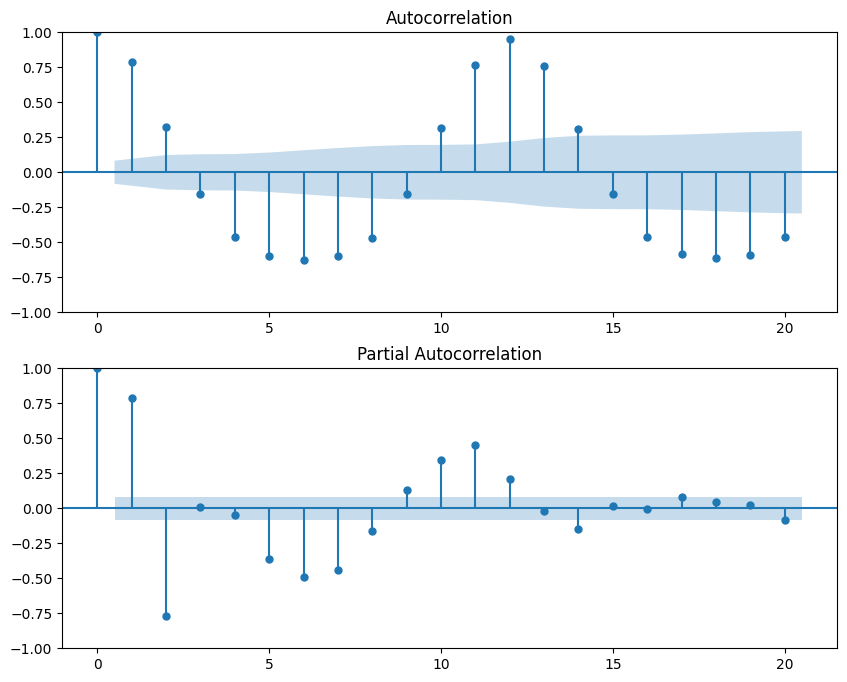

In [45]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_treino, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_treino, lags=20, ax=ax2)

O modelo ARIMA combina três componentes principais: autorregressivo (AR), diferenciado (I de Integrated, ou integrado) e de média móvel (MA), o que o torna capaz de modelar uma ampla variedade de dados temporais.

O modelo ARIMA é geralmente representado como ARIMA(p, d, q), onde:

- $(p)$ é o número de termos autoregressivos,
- $( d )$ é o número de diferenciações necessárias para tornar a série temporal estacionária,
- $( q )$ é o número de termos de média móvel.

A equação genérica do modelo ARIMA é:

$(1 - \sum_{i=1}^p \beta_i L^i)(1 - L)^d X_t = (1 + \sum_{j=1}^q \theta_j L^j) \epsilon_t$

In [46]:
arima_mod = ARIMA(df_treino, order=(14, 1, 2)).fit()
print(arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  563
Model:                ARIMA(14, 1, 2)   Log Likelihood                -544.664
Date:                Fri, 06 Jun 2025   AIC                           1123.329
Time:                        13:06:23   BIC                           1196.964
Sample:                    09-01-1965   HQIC                          1152.077
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4253      0.346     -1.229      0.219      -1.104       0.253
ar.L2          0.1354      0.362      0.374      0.708      -0.574       0.845
ar.L3         -0.2587      0.294     -0.879      0.3

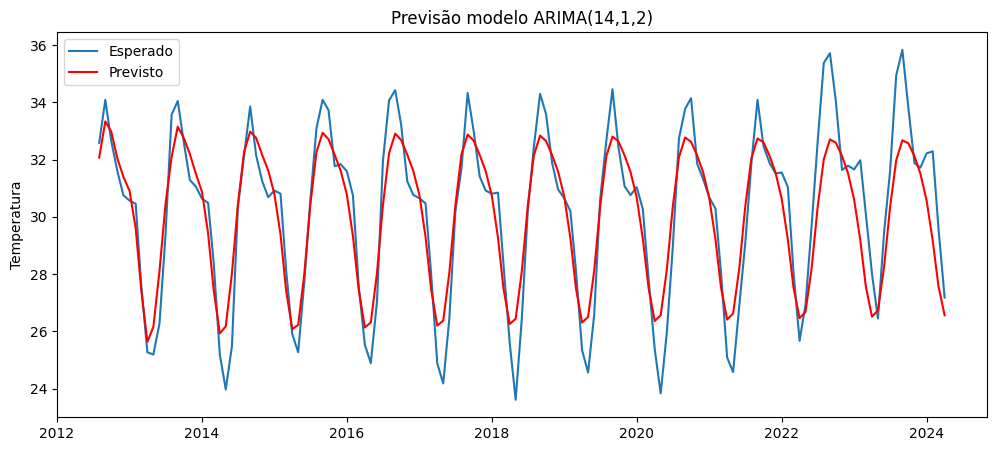


Métricas:

MAE: 1.0016324438508015
MSE: 1.590116909092425


In [47]:
plot_prev(df_treino, df_teste, arima_mod, 'ARIMA(14,1,2)')

### Busca de parâmetros

In [48]:
aic_arima = grid_arima(14,25,1,3,1,df_treino)

In [49]:
aic_arima[1]

(24, 1, 2)

In [50]:
arima_mod_ot = ARIMA(df_treino, order = (24, 1, 2)).fit()
print(arima_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  563
Model:                ARIMA(24, 1, 2)   Log Likelihood                -504.903
Date:                Fri, 06 Jun 2025   AIC                           1063.805
Time:                        13:07:26   BIC                           1180.756
Sample:                    09-01-1965   HQIC                          1109.464
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4460      0.151     -2.961      0.003      -0.741      -0.151
ar.L2          0.1553      0.085      1.832      0.067      -0.011       0.321
ar.L3         -0.1432      0.071     -2.030      0.0

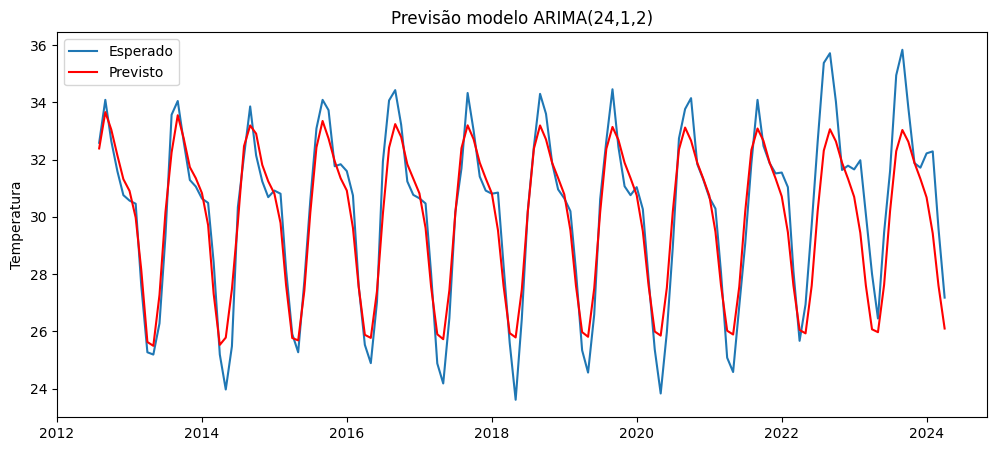


Métricas:

MAE: 0.8330080907591607
MSE: 1.1629090904079769


In [51]:
plot_prev(df_treino, df_teste, arima_mod_ot, 'ARIMA(24,1,2)')

### **A sazonalidade**

Text(0.5, 1.0, 'Sazonalidade - Temperatura média mensal - F3')

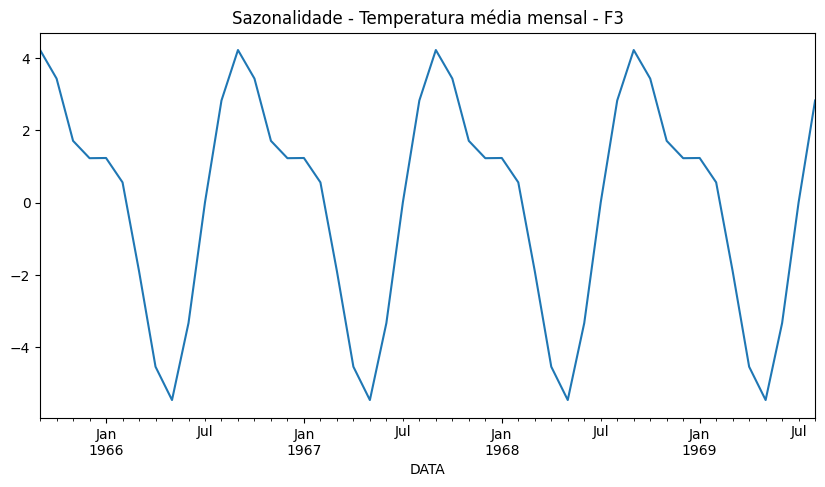

In [52]:
decomposicao_df = seasonal_decompose(df_f3)
fig = plt.figure(figsize=(10, 5))
decomposicao_df.seasonal.iloc[:48].plot()
plt.title('Sazonalidade - Temperatura média mensal - F3')

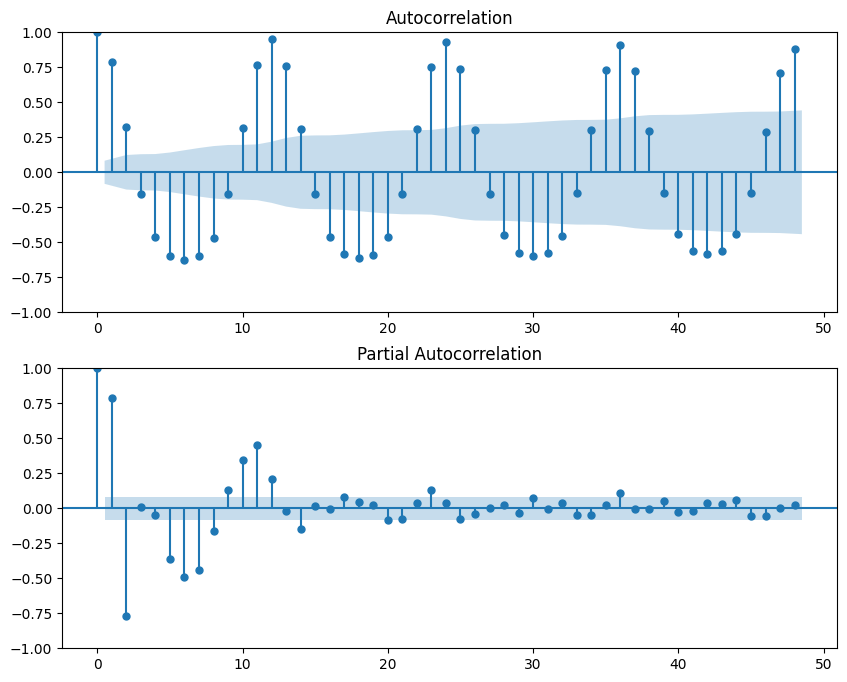

In [53]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_treino, lags=48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_treino, lags=48, ax=ax2)

## Modelo Autorregressivo Sazonal de Média Móveis Integrado (SARIMA)

O modelo SARIMA é uma extensão do modelo ARIMA, projetado especificamente para modelar e prever séries temporais que exibem sazonalidade.

O modelo SARIMA pode ser descrito pela seguinte equação, que combina tanto os efeitos sazonais quanto os não sazonais:

$(1 - \sum_{i=1}^p \beta_i L^i)(1 - \sum_{i=1}^P B_i L^{is})(1 - L)^d(1 - L^s)^D X_t = (1 + \sum_{j=1}^q \theta_j L^j)(1 + \sum_{j=1}^Q \Theta_j L^{js}) \epsilon_t$

In [54]:
sarima_mod = SARIMAX(df_treino, order=(11, 1, 1), seasonal_order=(2, 1, 1, 12)).fit()
print(sarima_mod.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                TEMP   No. Observations:                  563
Model:             SARIMAX(11, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -462.274
Date:                             Fri, 06 Jun 2025   AIC                            956.548
Time:                                     13:07:38   BIC                           1025.506
Sample:                                 09-01-1965   HQIC                           983.496
                                      - 07-01-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8513      0.170     -4.996      0.000      -1.185      -0.517
ar.L2         -0.7852      

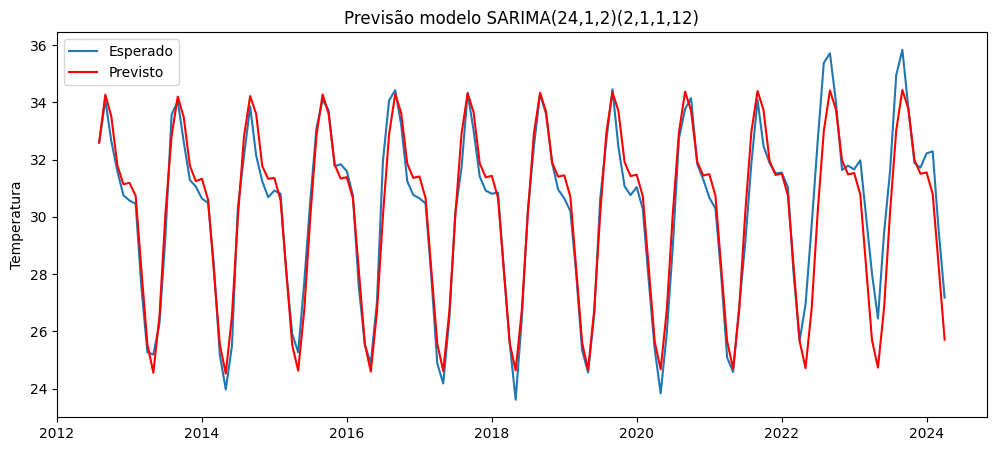


Métricas:

MAE: 0.5979545893591597
MSE: 0.7066816651581209


In [55]:
plot_prev(df_treino, df_teste, sarima_mod, 'SARIMA(24,1,2)(2,1,1,12)')

# Previsões das Fazendas

Temos 3 modelos para 3 conjuntos de dados sobre as temperaturas das fazendas

* Fazenda 1 modelo $AR(34)$
* Fazenda 2 modelo $ARMA(24,2)$
* Fazenda 3 modelo $SARIMA(24,1,2)(2,1,1,12)$

In [56]:
mod_f1 = AutoReg(df_f1, 34, old_names=False).fit()
mod_f2 = ARIMA(df_f2, order=(24,0,2)).fit()
mod_f3 = SARIMAX(df_f3, order=(11, 1, 1), seasonal_order=(2, 1, 1, 12)).fit()

In [57]:
previsao_f1 = mod_f1.predict(len(df_f1), len(df_f1) + 35, dynamic=False)
previsao_f2 = mod_f2.predict(len(df_f2), len(df_f2) + 35, dynamic=False)
previsao_f3 = mod_f3.predict(len(df_f3), len(df_f3) + 35, dynamic=False)